In [1]:
#Import the libraries we need
from   fredapi           import Fred
import seaborn           as sns
import numpy             as np
import pandas            as pd
import MetaTrader5       as mt5
import matplotlib.pyplot as plt

In [ ]:
#Define important variables
fred_api                = "ENTER YOUR API KEY"
fred_broad_dollar_index = "DTWEXBGS"
fred_us_10y             = "DGS10"
fred_us_5y_inflation    = "T5YIFR"

In [ ]:
#Login to fred
fred = Fred(api_key=fred_api)

In [ ]:
#Fetch the data
dollar_index    = fred.get_series(fred_broad_dollar_index)
us_10y          = fred.get_series(fred_us_10y)
us_5y_inflation = fred.get_series(fred_us_5y_inflation)

In [ ]:
#Name the series so we can merge the data
dollar_index.name    =  "Dollar Index"
us_10y.name          =  "Bond Interest"
us_5y_inflation.name =  "Inflation"

In [ ]:
#Fill in any missing values
dollar_index.fillna(dollar_index.rolling(window=5,min_periods=1).mean(),inplace=True)
us_10y.fillna(us_10y.rolling(window=5,min_periods=1).mean(),inplace=True)
us_5y_inflation.fillna(dollar_index.rolling(window=5,min_periods=1).mean(),inplace=True)

In [ ]:
#Initialize the terminal
mt5.initialize()

True

In [ ]:
#Define how much data to fetch
amount = 365 * 4
#Fetch data
eur_usd = pd.DataFrame(mt5.copy_rates_from_pos("EURUSD",mt5.TIMEFRAME_D1,0,amount))
eur_usd

time     open     high      low    close  tick_volume  spread  \
0     1549497600  1.13616  1.13684  1.13246  1.13378        63749       0   
1     1549584000  1.13379  1.13509  1.13212  1.13234        51920       0   
2     1549843200  1.13188  1.13299  1.12673  1.12748        57644       0   
3     1549929600  1.12754  1.13398  1.12576  1.13269        57553       0   
4     1550016000  1.13252  1.13415  1.12603  1.12612        63724       0   
...          ...      ...      ...      ...      ...          ...     ...   
1455  1726444800  1.10770  1.11377  1.10740  1.11326        56379       0   
1456  1726531200  1.11325  1.11463  1.11112  1.11140        65350       0   
1457  1726617600  1.11135  1.11889  1.10968  1.11176        68594       0   
1458  1726704000  1.11186  1.11789  1.10687  1.11615        78007       0   
1459  1726790400  1.11613  1.11819  1.11362  1.11629        65343       0   

      real_volume  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
1455            0  
1456            0  
1457            0  
1458            0  
1459            0  

[1460 rows x 8 columns]

In [ ]:
#Convert the time column
eur_usd['time'] = pd.to_datetime(eur_usd.loc[:,'time'],unit='s')

In [ ]:
#Set the column as the index
eur_usd.set_index('time',inplace=True)

In [5]:
#Define the forecast horizon
look_ahead = 20

In [6]:
#Define the predictors
predictors = ["open","high","low","close","tick_volume","Dollar Index","Bond Interest","Inflation"]
ohlc_predictors = ["open","high","low","close","tick_volume"]
fred_predictors = ["Dollar Index","Bond Interest","Inflation"]
target = "Target"
all_data = ["Target","open","high","low","close","tick_volume","Dollar Index","Bond Interest","Inflation"]
all_data_binary = ["Binary Target","open","high","low","close","tick_volume","Dollar Index","Bond Interest","Inflation"]

In [ ]:
#Merge our data
merged_data = eur_usd.merge(dollar_index,right_index=True,left_index=True)
merged_data = merged_data.merge(us_10y,right_index=True,left_index=True)
merged_data = merged_data.merge(us_5y_inflation,right_index=True,left_index=True)

In [ ]:
#Define the target
target         = merged_data.loc[:,"close"].shift(-look_ahead)
target.name    =  "Target"

In [ ]:
#Convert the data to yearly percent changes
merged_data = merged_data.loc[:,predictors].pct_change(periods = 365) * 100
merged_data = merged_data.merge(target,right_index=True,left_index=True)
merged_data.dropna(inplace=True)
merged_data

open      high       low     close  tick_volume  Dollar Index  \
2020-07-06 -1.041227 -0.200556 -0.760292 -0.254900    13.035499      4.249992   
2020-07-07 -0.254897 -0.161221 -0.551178 -0.432732    54.607088      4.440184   
2020-07-08 -0.407287  0.193294 -0.046151  0.487814    30.056901      3.941361   
2020-07-09  0.454973  0.273373  0.202530 -0.371682    55.602662      4.178848   
2020-07-10 -0.388514 -0.147247 -0.047068  0.335666    16.411399      3.846656   
...              ...       ...       ...       ...          ...           ...   
2024-08-12  3.191862  2.857385  3.402489  2.998926   -41.358261      1.431775   
2024-08-13  3.046700  2.941397  2.915688  3.076505   -17.274405      1.389562   
2024-08-14  2.847012  2.950386  3.300631  2.690278   -21.732835      1.356311   
2024-08-15  2.745822  2.108746  2.295404  1.870044    -6.241015      1.592017   
2024-08-16  1.916182  1.074924  1.924882  1.598327   -20.580673      1.662216   

            Bond Interest  Inflation   Target  
2020-07-06     -73.962264 -18.592965  1.17627  
2020-07-07     -75.285171 -17.948718  1.18027  
2020-07-08     -74.716981 -18.461538  1.18641  
2020-07-09     -76.865672 -20.000000  1.18768  
2020-07-10     -76.014760 -19.897959  1.17868  
...                   ...        ...      ...  
2024-08-12       9.550562   2.752294  1.10353  
2024-08-13      13.569322   5.714286  1.10191  
2024-08-14      10.374640   2.336449  1.10111  
2024-08-15       9.192201   1.809955  1.10746  
2024-08-16      11.781609  -2.666667  1.10744  

[1070 rows x 9 columns]

In [ ]:
#Add binary targets for plotting purposes
merged_data["Binary Target"] = 0
merged_data.loc[merged_data["close"] < merged_data["Target"],"Binary Target"] = 1

In [ ]:
#Reset the index
merged_data.reset_index(inplace=True,drop=True)
merged_data

open      high       low     close  tick_volume  Dollar Index  \
0    -1.041227 -0.200556 -0.760292 -0.254900    13.035499      4.249992   
1    -0.254897 -0.161221 -0.551178 -0.432732    54.607088      4.440184   
2    -0.407287  0.193294 -0.046151  0.487814    30.056901      3.941361   
3     0.454973  0.273373  0.202530 -0.371682    55.602662      4.178848   
4    -0.388514 -0.147247 -0.047068  0.335666    16.411399      3.846656   
...        ...       ...       ...       ...          ...           ...   
1065  3.191862  2.857385  3.402489  2.998926   -41.358261      1.431775   
1066  3.046700  2.941397  2.915688  3.076505   -17.274405      1.389562   
1067  2.847012  2.950386  3.300631  2.690278   -21.732835      1.356311   
1068  2.745822  2.108746  2.295404  1.870044    -6.241015      1.592017   
1069  1.916182  1.074924  1.924882  1.598327   -20.580673      1.662216   

      Bond Interest  Inflation   Target  Binary Target  
0        -73.962264 -18.592965  1.17627              1  
1        -75.285171 -17.948718  1.18027              1  
2        -74.716981 -18.461538  1.18641              1  
3        -76.865672 -20.000000  1.18768              1  
4        -76.014760 -19.897959  1.17868              1  
...             ...        ...      ...            ...  
1065       9.550562   2.752294  1.10353              0  
1066      13.569322   5.714286  1.10191              0  
1067      10.374640   2.336449  1.10111              0  
1068       9.192201   1.809955  1.10746              0  
1069      11.781609  -2.666667  1.10744              0  

[1070 rows x 10 columns]

<Axes: >

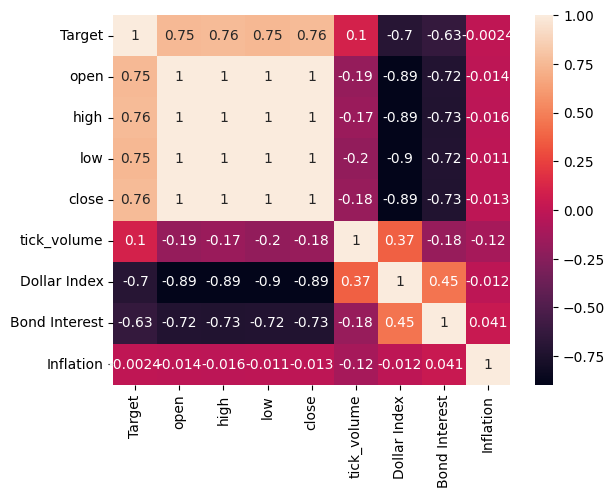

In [ ]:
#Exploratory data analysis
sns.heatmap(merged_data.loc[:,all_data].corr(),annot=True)

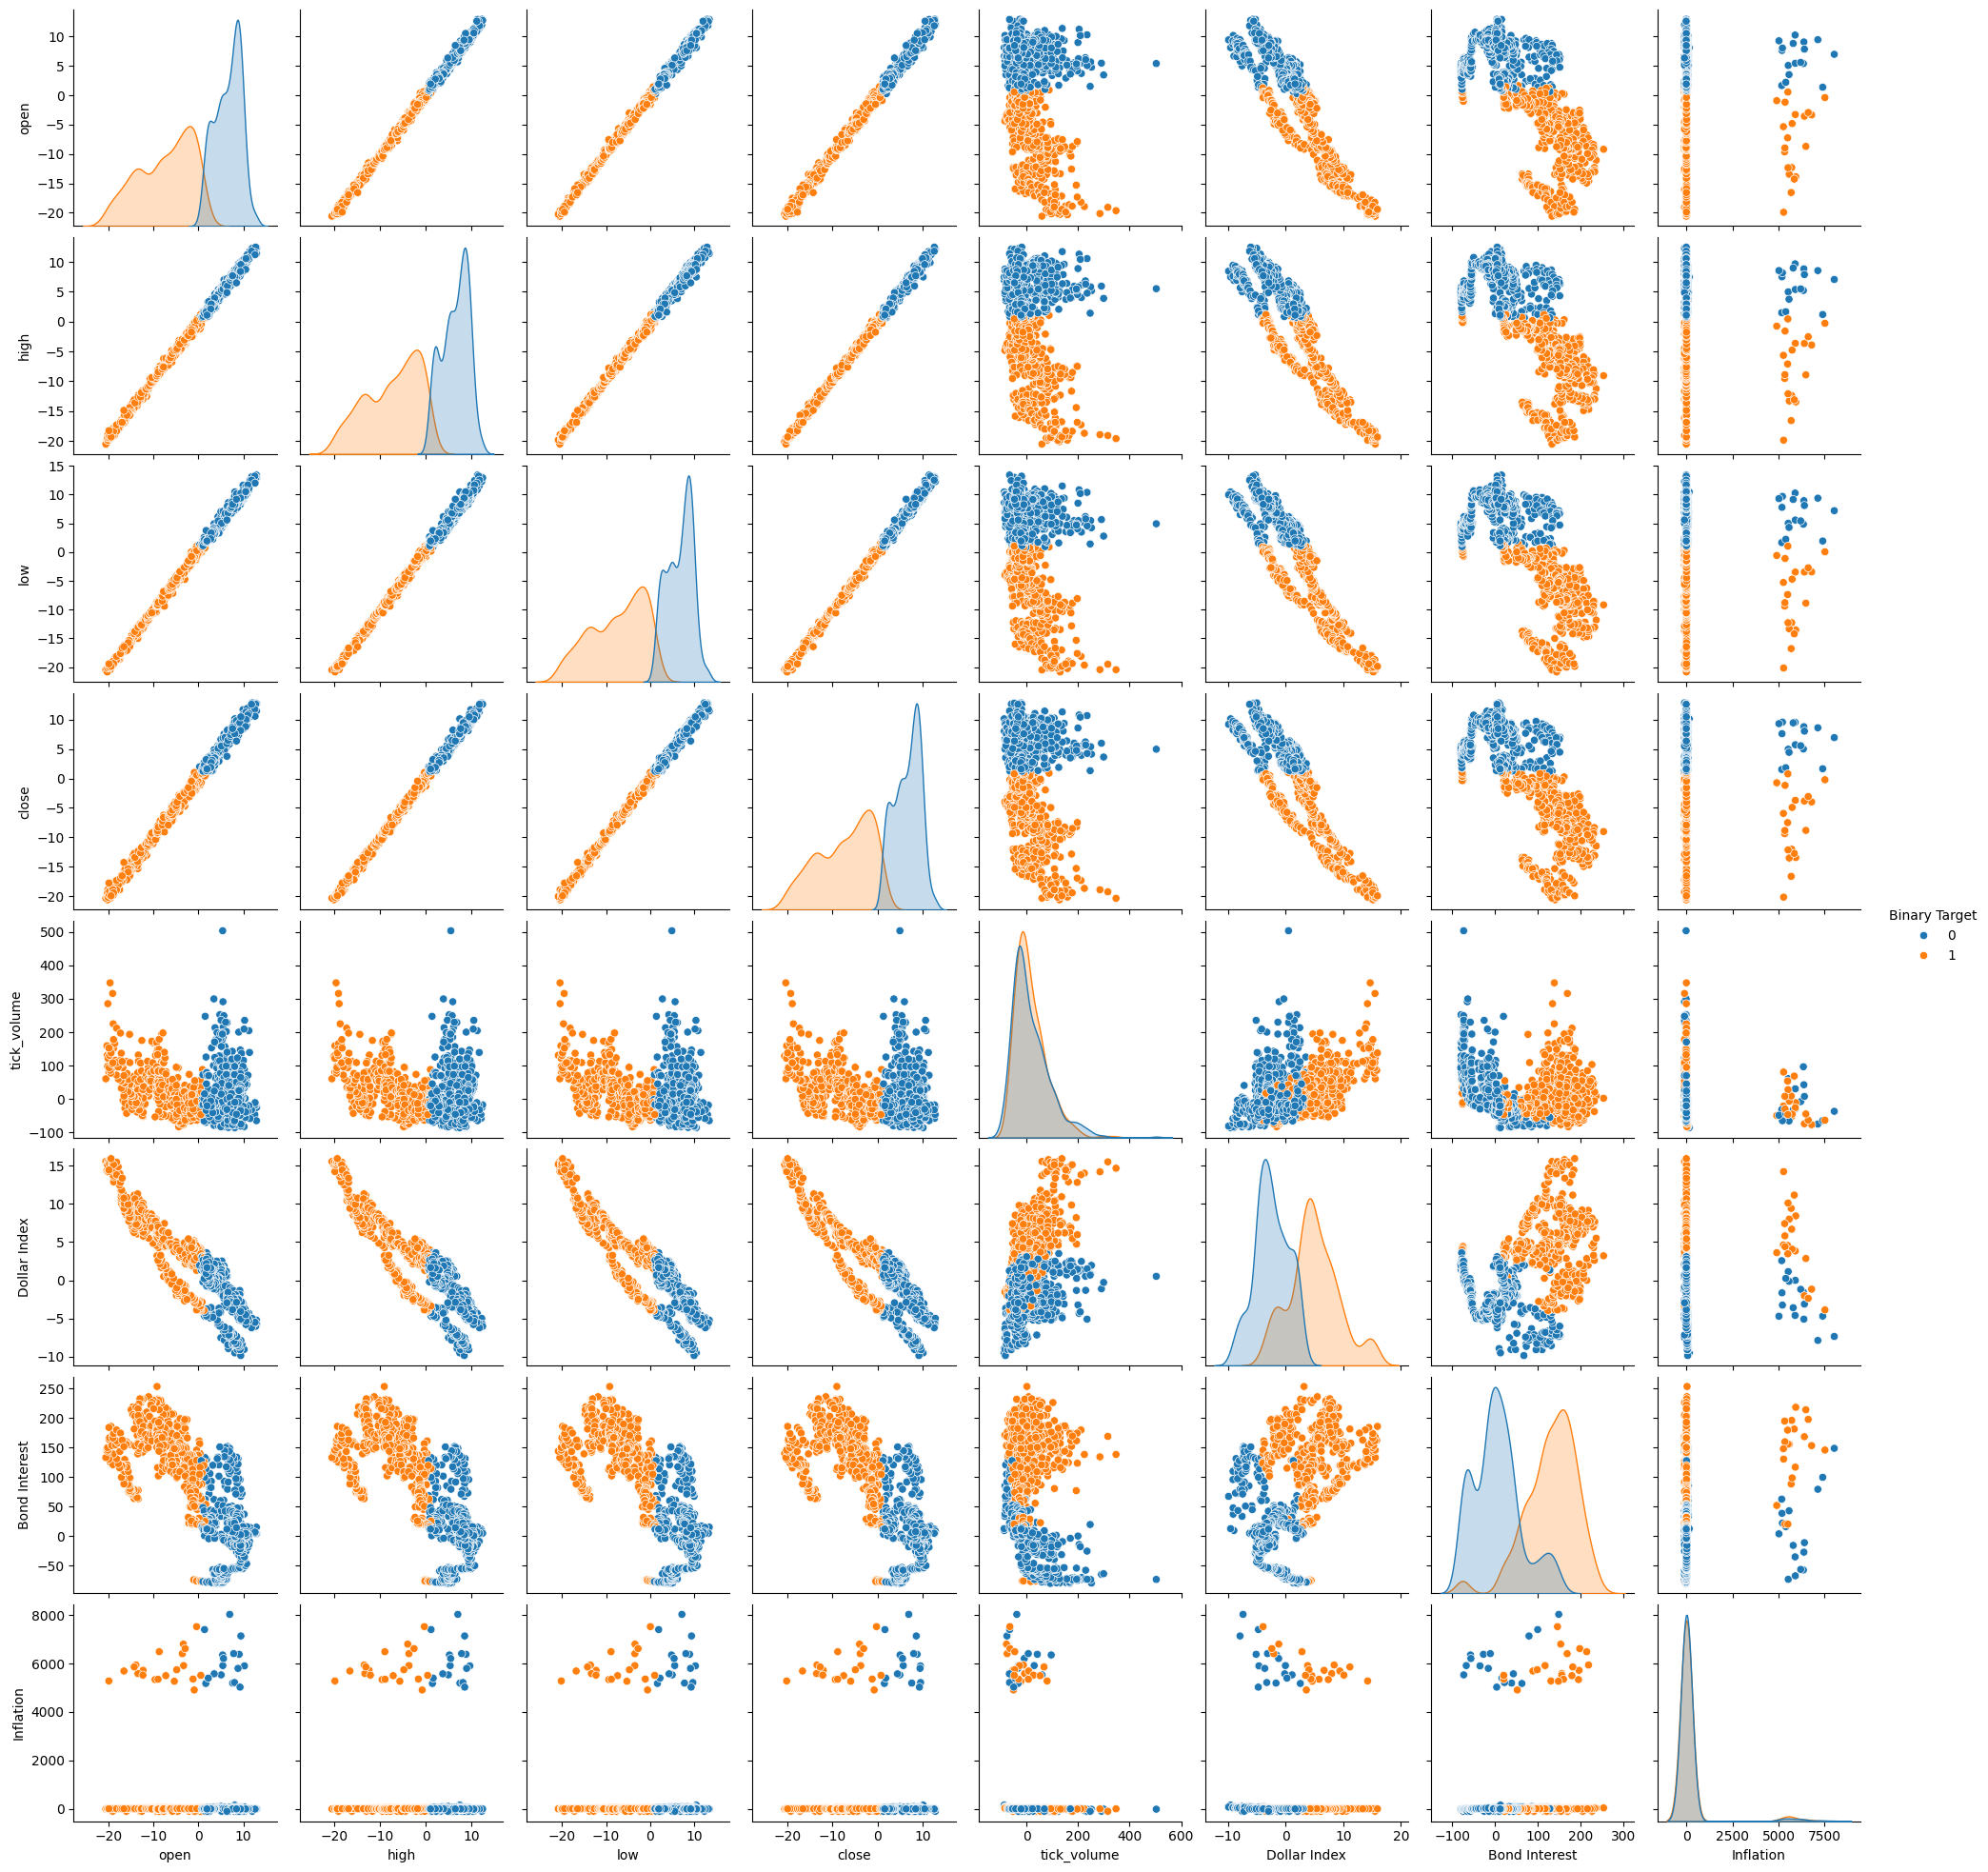

In [ ]:
sns.pairplot(merged_data.loc[:,all_data_binary],hue="Binary Target")

Text(0.5, 0, 'EURUSD close')

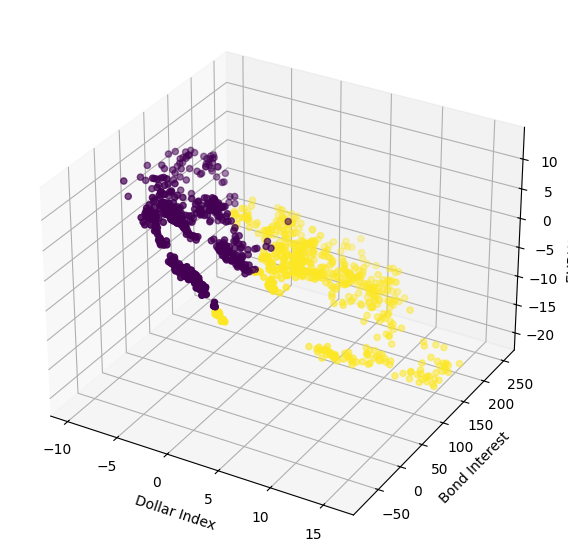

In [ ]:
#Define the 3D Plot
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection="3d")
ax.scatter(merged_data["Dollar Index"],merged_data["Bond Interest"],merged_data["close"],c=merged_data["Binary Target"])
ax.set_xlabel("Dollar Index")
ax.set_ylabel("Bond Interest")
ax.set_zlabel("EURUSD close")

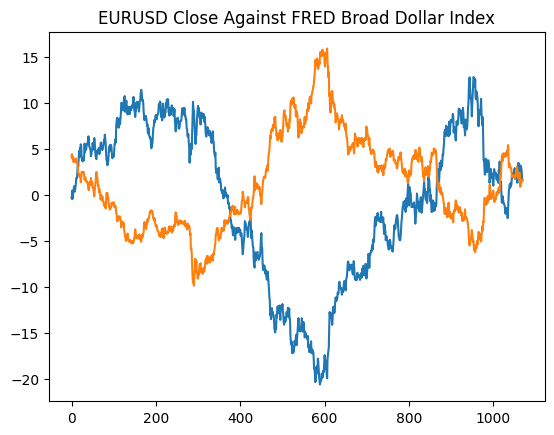

In [18]:
#Plotting our data set
plt.title("EURUSD Close Against FRED Broad Dollar Index")
plt.plot(merged_data.loc[:,"close"])
plt.plot(merged_data.loc[:,"Dollar Index"])

In [7]:
#Let's define our set of predictors
X = merged_data.loc[:,predictors]
y = merged_data.loc[:,"Target"]

In [8]:
#Import the libraries we need
from sklearn.model_selection import train_test_split

In [9]:
#Partition the data
ohlc_train_X,ohlc_test_X,train_y,test_y = train_test_split(X.loc[:,ohlc_predictors],y,test_size=0.5,shuffle=False)
fred_train_X,fred_test_X,_,_            = train_test_split(X.loc[:,fred_predictors],y,test_size=0.5,shuffle=False)
train_X,test_X,_,_                      = train_test_split(X.loc[:,predictors],y,test_size=0.5,shuffle=False)

In [10]:
#Prepare the dataframe to store our validation error
validation_error = pd.DataFrame(columns=["MT5 Data","FRED Data","ALL Data"],index=np.arange(0,5))

In [11]:
#Let's cross validate our models
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
#Save the data to csv
merged_data.to_csv("merged_data.csv")

In [12]:
#Define the neural networks
ohlc_nn = MLPRegressor(hidden_layer_sizes=(10,20,40),max_iter=500)
fred_nn = MLPRegressor(hidden_layer_sizes=(10,20,40),max_iter=500)
all_nn  = MLPRegressor(hidden_layer_sizes=(10,20,40),max_iter=500)

In [13]:
#Let's obtain our cv score
ohlc_score = cross_val_score(ohlc_nn,ohlc_train_X,train_y,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1)

In [14]:
fred_score = cross_val_score(fred_nn,fred_train_X,train_y,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1)

In [15]:
all_score = cross_val_score(all_nn,train_X,train_y,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1)

In [19]:
for i in np.arange(0,5):
    validation_error.iloc[i,0] = ohlc_score[i]
    validation_error.iloc[i,1] = fred_score[i]
    validation_error.iloc[i,2] = all_score[i]

In [20]:
#Our validation error
validation_error

MT5 Data FRED Data  ALL Data
0 -0.147973  -0.79131 -4.816608
1 -0.103913 -2.073764 -0.655701
2 -0.211833 -0.276794 -0.838832
3 -0.094998 -1.954753 -0.259959
4 -1.233912 -2.152471 -3.677273

In [21]:
#Our mean performane across all groups
validation_error.mean()

MT5 Data    -0.358526
FRED Data   -1.449818
ALL Data    -2.049675
dtype: object

<Axes: >

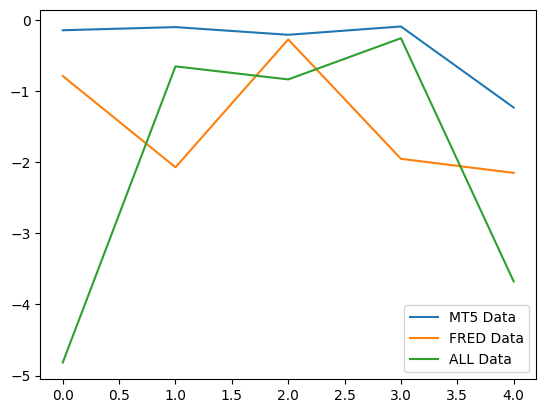

In [22]:
#Plotting our performance
validation_error.plot()

<Axes: >

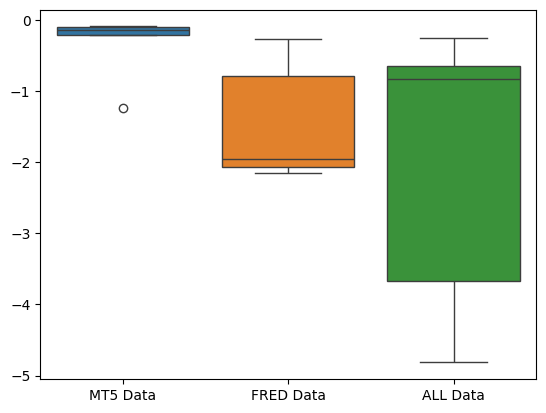

In [23]:
#Creating box-plots of our performance
sns.boxplot(validation_error)

In [ ]:
#Feature importance
from alibi.explainers import ALE, plot_ale

In [ ]:
#Explaining our deep neural network
model = MLPRegressor(hidden_layer_sizes=(10,20,40),max_iter=500)
model.fit(train_X,train_y)
dnn_ale = ALE(model.predict,feature_names=predictors,target_names=["Target"])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegress

array([[<Axes: xlabel='open', ylabel='ALE'>,
        <Axes: xlabel='high', ylabel='ALE'>,
        <Axes: xlabel='low', ylabel='ALE'>],
       [<Axes: xlabel='close', ylabel='ALE'>,
        <Axes: xlabel='tick_volume', ylabel='ALE'>,
        <Axes: xlabel='Dollar Index', ylabel='ALE'>],
       [<Axes: xlabel='Bond Interest', ylabel='ALE'>,
        <Axes: xlabel='Inflation', ylabel='ALE'>, None]], dtype=object)

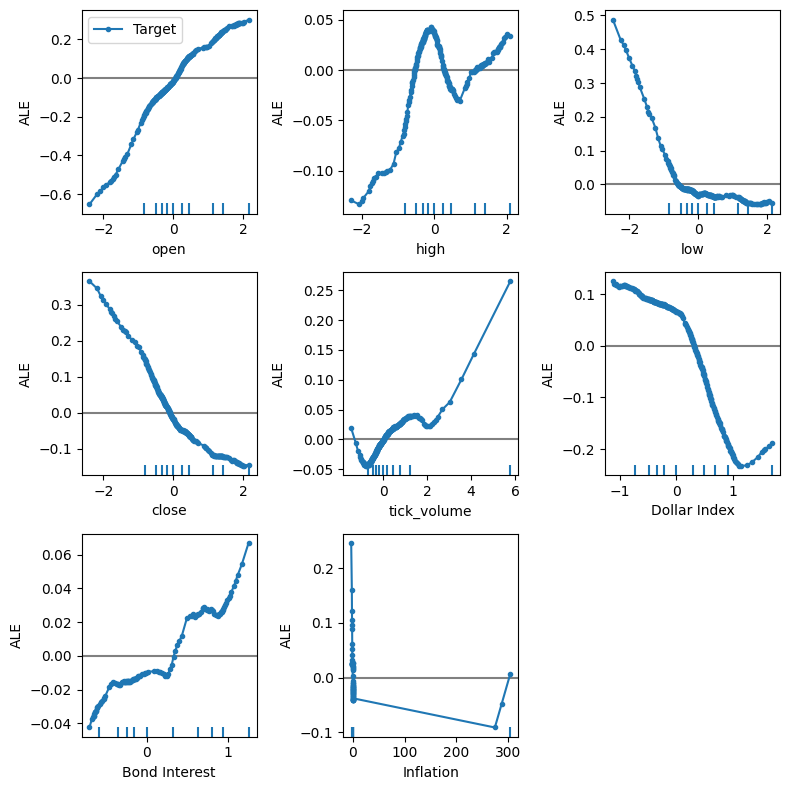

In [ ]:
#Obtaining the explanation
ale_X = X.to_numpy()
dnn_explanations = dnn_ale.explain(ale_X)
#Plotting feature importance
plot_ale(dnn_explanations,n_cols=3,fig_kw={'figwidth':8,'figheight':8},sharey=None)

In [ ]:
#Backward selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [ ]:
#Reinitialize the model
all_nn  = MLPRegressor(hidden_layer_sizes=(10,20,40),max_iter=500)

In [ ]:
#Define the feature selector
sfs1 = SFS(all_nn,
           k_features=(1,X.shape[1]),
           forward=True,
           scoring='neg_mean_squared_error',
           cv=5,
           n_jobs=-1
          )

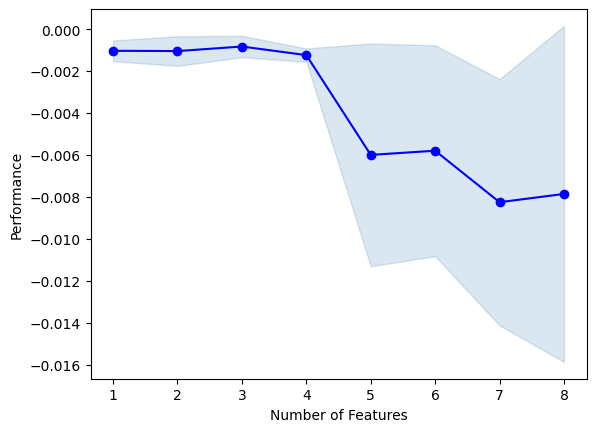

In [ ]:
#Fit the forward selection algorithm
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

In [ ]:
#Best features we identified
sfs1.k_feature_names_

('open', 'high', 'low')

In [ ]:
#Parameter tuning
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Reinitialize the model
model  = MLPRegressor(max_iter=500)

In [ ]:
#Define the tuner
tuner = RandomizedSearchCV(
        model,
        {
        "activation" : ["relu","logistic","tanh","identity"],
        "solver":["adam","sgd","lbfgs"],
        "alpha":[0.1,0.01,0.001,0.0001,0.00001,0.00001,0.0000001],
        "tol":[0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001],
        "learning_rate":['constant','adaptive','invscaling'],
        "learning_rate_init":[0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001],
        "hidden_layer_sizes":[(10,20,40),(10,20,40,80),(5,10,20,100),(100,50,10),(20,20,10),(1,5,10,20),(20,10,5,1)],
        "early_stopping":[True,False],
        "warm_start":[True,False],
        "shuffle": [True,False]
        },
        n_iter=500,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error"
)

In [ ]:
#Fit the tuner
tuner.fit(train_X,train_y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
134 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
58 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklea

RandomizedSearchCV(cv=5, estimator=MLPRegressor(max_iter=500), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'logistic',
                                                       'tanh', 'identity'],
                                        'alpha': [0.1, 0.01, 0.001, 0.0001,
                                                  1e-05, 1e-05, 1e-07],
                                        'early_stopping': [True, False],
                                        'hidden_layer_sizes': [(10, 20, 40),
                                                               (10, 20, 40, 80),
                                                               (5, 10, 20, 100),
                                                               (100, 50, 10),
                                                               (20, 20, 10),
                                                               (1, 5, 10, 20),
                                                               (20, 10, 5, 1)],
                                        'learning_rate': ['constant',
                                                          'adaptive',
                                                          'invscaling'],
                                        'learning_rate_init': [0.1, 0.01, 0.001,
                                                               0.0001, 1e-05,
                                                               1e-06, 1e-07],
                                        'shuffle': [True, False],
                                        'solver': ['adam', 'sgd', 'lbfgs'],
                                        'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05,
                                                1e-06, 1e-07],
                                        'warm_start': [True, False]},
                   scoring='neg_mean_squared_error')

In [ ]:
#The best parameters we found
tuner.best_params_

{'warm_start': False,
 'tol': 1e-05,
 'solver': 'lbfgs',
 'shuffle': True,
 'learning_rate_init': 0.01,
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (10, 20, 40, 80),
 'early_stopping': True,
 'alpha': 0.1,
 'activation': 'relu'}

In [ ]:
#Deeper optimization
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
#Define the time series split object
tscv = TimeSeriesSplit(n_splits=5,gap=look_ahead)

In [ ]:
#Create a dataframe to store our accuracy
current_error_rate = pd.DataFrame(index = np.arange(0,5),columns=["Current Error"])
algorithm_progress = []

In [ ]:
#Define the objective function
def objective(x):
    #The parameter x represents a new value for our neural network's settings
    #In order to find optimal settings, we will perform 10 fold cross validation using the new setting
    #And return the average RMSE from all 10 tests
    #We will first turn the model's Alpha parameter, which controls the amount of L2 regularization
    model = MLPRegressor(hidden_layer_sizes=tuner.best_params_["hidden_layer_sizes"],
                         early_stopping=tuner.best_params_["early_stopping"],
                         warm_start=tuner.best_params_["warm_start"],
                         max_iter=500,
                         activation=tuner.best_params_["activation"],
                         learning_rate=tuner.best_params_["learning_rate"],
                         solver=tuner.best_params_["solver"],
                         shuffle=tuner.best_params_["shuffle"],
                         alpha=x[0],
                         tol=x[1],
                         learning_rate_init=x[2]
                         )
    #Now we will cross validate the model
    for i,(train,test) in enumerate(tscv.split(train_X)):
        #Train the model
        model.fit(train_X.loc[train[0]:train[-1],:],train_y.loc[train[0]:train[-1]])
        #Measure the RMSE
        current_error_rate.iloc[i,0] = mean_squared_error(train_y.loc[test[0]:test[-1]],model.predict(train_X.loc[test[0]:test[-1],:]))
    #Store the algorithm's progress
    algorithm_progress.append(current_error_rate.iloc[:,0].mean())
    #Return the Mean CV RMSE
    return(current_error_rate.iloc[:,0].mean())

In [ ]:
#Define the starting point
pt = [tuner.best_params_["alpha"],tuner.best_params_["tol"],tuner.best_params_["learning_rate_init"]]
bnds = ((10.00 ** -100,10.00 ** 100),
        (10.00 ** -100,10.00 ** 100),
        (10.00 ** -100,10.00 ** 100))

In [ ]:
#Searchin deeper for parameters
result = minimize(objective,pt,method="TNC",bounds=bnds)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

In [ ]:
#The result of our optimization
result

 message: Linear search failed
 success: False
  status: 4
     fun: 0.001911232280110637
       x: [ 1.000e-100  1.000e-100  1.000e-100]
     nit: 0
     jac: [ 2.689e+06  9.227e+04  1.124e+05]
    nfev: 116

<ipython-input-79-fa12921cd4ba>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(optima_x,optima_y,'ro',color='r')


Text(0.5, 1.0, 'Minimizing Training Error')

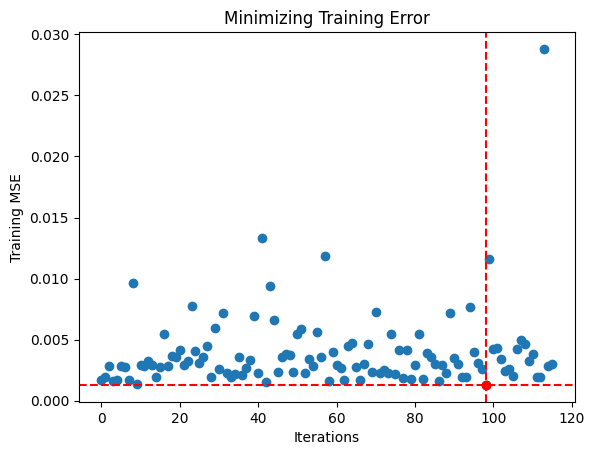

In [ ]:
#Store the optimal coefficients
optimal_weights = result.x
optima_y = min(algorithm_progress)
optima_x = algorithm_progress.index(optima_y)
inputs = np.arange(0,len(algorithm_progress))

#Plot the performance of our optimization procedure
plt.scatter(inputs,algorithm_progress)
plt.plot(optima_x,optima_y,'ro',color='r')
plt.axvline(x=optima_x,ls='--',color='red')
plt.axhline(y=optima_y,ls='--',color='red')
plt.xlabel("Iterations")
plt.ylabel("Training MSE")
plt.title("Minimizing Training Error")

In [ ]:
#Testing for overfitting
default_nn = MLPRegressor(max_iter=500)

#Randomized NN
random_search_nn = MLPRegressor(hidden_layer_sizes=tuner.best_params_["hidden_layer_sizes"],
                         early_stopping=tuner.best_params_["early_stopping"],
                         warm_start=tuner.best_params_["warm_start"],
                         max_iter=500,
                         activation=tuner.best_params_["activation"],
                         learning_rate=tuner.best_params_["learning_rate"],
                         solver=tuner.best_params_["solver"],
                         shuffle=tuner.best_params_["shuffle"],
                         alpha=tuner.best_params_["alpha"],
                         tol=tuner.best_params_["tol"],
                         learning_rate_init=tuner.best_params_["learning_rate_init"]
                         )

#TNC NN
tnc_nn = MLPRegressor(hidden_layer_sizes=tuner.best_params_["hidden_layer_sizes"],
                         early_stopping=tuner.best_params_["early_stopping"],
                         warm_start=tuner.best_params_["warm_start"],
                         max_iter=500,
                         activation=tuner.best_params_["activation"],
                         learning_rate=tuner.best_params_["learning_rate"],
                         solver=tuner.best_params_["solver"],
                         shuffle=tuner.best_params_["shuffle"],
                         alpha=result.x[0],
                         tol=result.x[1],
                         learning_rate_init=result.x[2]
                         )

In [ ]:
#Store the models in a list
models = [default_nn,random_search_nn,tnc_nn]

#Fit the models
for model in models:
    model.fit(train_X,train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
#Create a dataframe to store our validation error
validation_error = pd.DataFrame(columns=["Default","Randomized","TNC"],index=np.arange(0,5))

In [ ]:
#Let's obtain our cv score
default_score = cross_val_score(default_nn,test_X,test_y,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1)
random_score = cross_val_score(random_search_nn,test_X,test_y,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1)
tnc_score = cross_val_score(tnc_nn,test_X,test_y,scoring='neg_root_mean_squared_error',cv=5,n_jobs=-1)

#Store the model error in a dataframe
for i in np.arange(0,5):
    validation_error.iloc[i,0] = default_score[i]
    validation_error.iloc[i,1] = random_score[i]
    validation_error.iloc[i,2] = tnc_score[i]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
#Let's see the validation error
validation_error

Default Randomized       TNC
0 -0.362851  -0.029476 -0.054709
1 -0.323601  -0.053967 -0.087707
2 -0.064432  -0.024282 -0.026481
3 -0.121226  -0.019693 -0.017709
4 -0.064801  -0.012812 -0.016125

In [ ]:
#Our best performing model
validation_error.mean()

Default      -0.187382
Randomized   -0.028046
TNC          -0.040546
dtype: object

<Axes: >

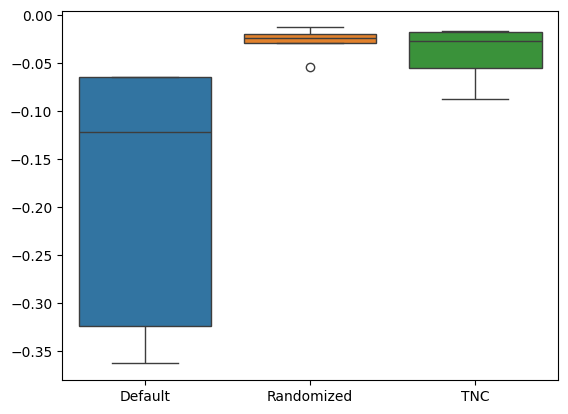

In [ ]:
#Let's create box-plots
sns.boxplot(validation_error)

<Axes: >

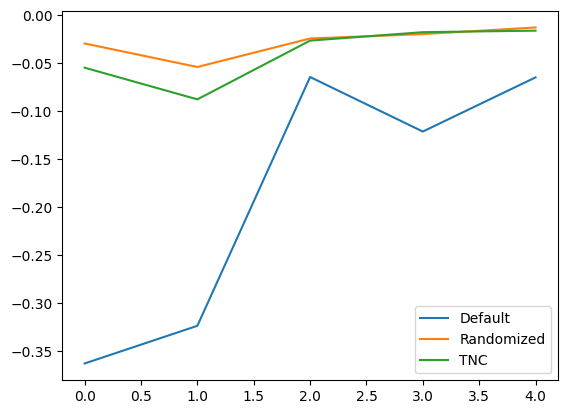

In [ ]:
#We can also visualize model performance through a line plot
validation_error.plot()

In [ ]:
#Resdiuals analysis
model = MLPRegressor(hidden_layer_sizes=tuner.best_params_["hidden_layer_sizes"],
                         early_stopping=tuner.best_params_["early_stopping"],
                         warm_start=tuner.best_params_["warm_start"],
                         max_iter=500,
                         activation=tuner.best_params_["activation"],
                         learning_rate=tuner.best_params_["learning_rate"],
                         solver=tuner.best_params_["solver"],
                         shuffle=tuner.best_params_["shuffle"],
                         alpha=tuner.best_params_["alpha"],
                         tol=tuner.best_params_["tol"],
                         learning_rate_init=tuner.best_params_["learning_rate_init"]
                         )

In [ ]:
#Fit the model
model.fit(train_X,train_y)

#Record the residuals
residuals = test_y - model.predict(test_X)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


<Axes: >

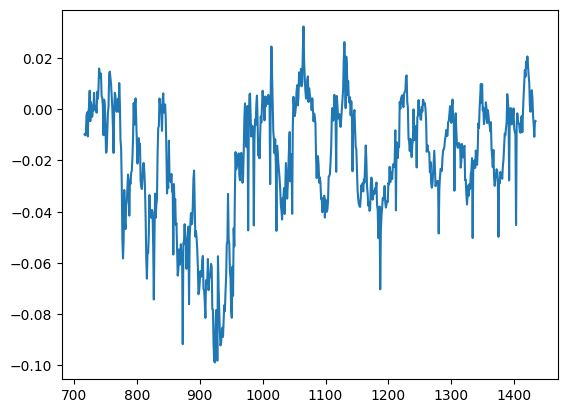

In [ ]:
#Residuals analysis
residuals.plot()

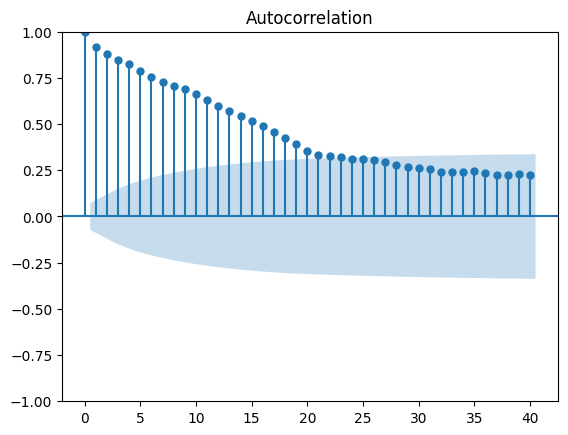

In [ ]:
#Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(residuals,lags=40)

In [ ]:
#Prepare to convert the model to ONNX format
scale_factors = pd.DataFrame(columns=X.columns,index=["mean","std"])
for i in X.columns:
    scale_factors.loc["mean",i] = merged_data.loc[:,i].mean()
    scale_factors.loc["std",i]  = merged_data.loc[:,i].std()
    merged_data.loc[:,i] = (merged_data.loc[:,i] - scale_factors.loc["mean",i]) / scale_factors.loc["std",i]

scale_factors

open      high       low     close   tick_volume Dollar Index  \
mean  1.111357   1.11526  1.107818  1.111491  65505.271777   118.157138   
std   0.054674  0.054133  0.055054  0.054631  26512.506288     4.011255   

     Bond Interest  Inflation  
mean      2.496246   6.218922  
std       1.288031  21.537341

In [ ]:
#Save the scale factors to CSV format
scale_factors.to_csv("FRED EURUSD D1 scale factors.csv")

In [ ]:
#Resdiuals analysis
model = MLPRegressor(hidden_layer_sizes=tuner.best_params_["hidden_layer_sizes"],
                         early_stopping=tuner.best_params_["early_stopping"],
                         warm_start=tuner.best_params_["warm_start"],
                         max_iter=500,
                         activation=tuner.best_params_["activation"],
                         learning_rate=tuner.best_params_["learning_rate"],
                         solver=tuner.best_params_["solver"],
                         shuffle=tuner.best_params_["shuffle"],
                         alpha=tuner.best_params_["alpha"],
                         tol=tuner.best_params_["tol"],
                         learning_rate_init=tuner.best_params_["learning_rate_init"]
                         )

In [ ]:
# Import the libraries we need
import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

In [ ]:
# Fit the model on all the data we have
model.fit(merged_data.loc[:,predictors],merged_data.loc[:,target])

MLPRegressor(alpha=0.1, early_stopping=True,
             hidden_layer_sizes=(10, 20, 40, 80), learning_rate='invscaling',
             learning_rate_init=0.01, max_iter=500, solver='lbfgs', tol=1e-05)

In [ ]:
# Define the input type
initial_types = [("float_input",FloatTensorType([1,X.shape[1]]))]

In [ ]:
# Create the ONNX representation
onnx_model = convert_sklearn(model,initial_types=initial_types,target_opset=12)

In [ ]:
# Save the ONNX model
onnx.save_model(onnx_model,"FRED EURUSD D1.onnx")